# Introduction

This notebook outlines how the random_walk code was developed, how it can be used, and how to visiualize the walk and perform statistics on it. 

The Random Positioning Machine that this code is designed to work with was built by FireFly Biotech in Adelaide South Australia. The RMP is made of acrylic and uses light stepper motors to drive the axis. The unit is controlled by sending G-code commands to a controller via a USB cable from a laptop. The RPM has axes which are referred to as "X" & "Y". The laptop software is Universal G-code Sender. 

![RPM from wikipedia](/img/Wikipedia_RPM.png)


## Axes 

The rpm axes can be set to zero by powering down the unit then moving the axes by hand. For my experiments the "frames" are horizontal. The G-code is agnostic to the original configuration. The unit will move relative to its last position. The outer frame is controlled by the "X" axis and the iner is the "Y" axis. At a value of $\sim 15.5$ the axis will have rotated $\pi$ radians. The original random walk code that was supplied by Firefly Biotech walked over a domain that was $2\pi$ radians.

For partial gravity the range of rotation will be restricted. As the rotation range is restricted the time averaged gravity approaches a constant partial gravity value. For partial gravity testing, the time averaged gravitational acceleration will approach zero when the rotation maximum is set to $\pi$ radians. For small maximum rotation space the time averaged gravity will be nearly one.



## Motion Directions
The hardware developers, who have also developed the zero-g random walk path, suggest having both axes rotate at the same speed so they arrive at the same place at the same time. Literature review has not suggested why this may be, but this practice will be continued here. To do this the directions in the code are set to [(1,1),(1,-1),(-1,-1),(-1,1)], or [NE,NW,SW,SE].

## Sudo Code 
![Alt text](/img/pseudo_code.png)

# Using the random_walk.py script

In [1]:
#import the appropriate libararies
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

#import the random walk script
from random_walk import RandomWalk2D

#auto reload modules for development
%load_ext autoreload
%autoreload 2

In [12]:
# Load the resample function and RPM coordinates to cartesian functions from the utilities script
from utilities import interpolate_points
from utilities import rpm2cartesian

In [2]:
# this cell makes sure everything is loaded correctly
# format is RandomWalk2D(#points,x_max,y_max)
max = 10
RandomWalk2D(100,max,max).generate_walk().get_path()

,Theta,Phi,Dir,X,Y,Z
0,0.000000,0.000000,"(1, 1)",0.000000,0.000000,-1.000000
1,2.273360,2.273360,"(1, 1)",0.398268,0.444640,-0.802295
2,-0.174117,4.720838,"(1, -1)",-0.020327,0.817373,-0.575751
3,-8.008937,-3.113982,"(-1, -1)",-0.806236,-0.590076,0.042352
4,-9.355403,-1.767516,"(1, -1)",-0.887371,-0.350632,0.299382
...,...,...,...,...,...,...
96,-1.290082,3.055650,"(1, -1)",-0.210495,0.580489,-0.786590
97,0.626192,4.971923,"(1, 1)",0.067566,0.845620,-0.529491
98,9.682266,-4.084152,"(-1, 1)",0.625283,-0.736438,0.258224
99,9.337949,-4.428470,"(-1, -1)",0.591490,-0.781819,0.197229


# Path Analysis

The random positioning code needs to be examined for several key metrics.
1. Average gravity as a function of maximum X & Y, (taken as equal for this testing)
2. Width of time window to achieve the desired average gravity

## Average gravity

In [7]:
# Average gravity as a function of limited rotation
# For 5000 points this takes about 6min on a laptop.
MaxTheta = np.linspace(3,15.5)  #np.array([3,6,9,12,15]) 
gravity = [RandomWalk2D(5000,i,i).generate_walk().get_path() for i in MaxTheta]
x_path = xr.concat([grav.to_xarray() for grav in gravity],dim='MaxTheta')
x_path['MaxTheta'] = ('MaxTheta',MaxTheta)

### Save the paths as an hdf5 xarray file (Optional)

In [8]:
x_path['index'].shape[0]

5001

In [9]:
# Save to an hdf5 file, this is optional.
# Need to drop the tuple because the netcdf file doesn't this  
x_path.drop('Dir').to_netcdf('x_path.nc')

ValueError: cannot read or write netCDF files without netCDF4-python or scipy installed

In [3]:
#load file if there is no x_path variable
x_path = xr.open_dataset("x_path.nc", engine='netcdf4')
print(x_path)

<xarray.Dataset>
Dimensions:   (index: 5001, MaxTheta: 5)
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999 5000
  * MaxTheta  (MaxTheta) int32 3 6 9 12 15
Data variables:
    Theta     (MaxTheta, index) float64 ...
    Phi       (MaxTheta, index) float64 ...
    X         (MaxTheta, index) float64 ...
    Y         (MaxTheta, index) float64 ...
    Z         (MaxTheta, index) float64 ...


Because the higher MaxTheta can have longer segments between each turn there will be more total points in the extended, evenly spaced, dataset. This is why there is a min_path line in the following code. 

In [11]:
# Resample the data from the random walk
step_size = 0.01
path_list = []

for i,max in enumerate(MaxTheta):
    data = interpolate_points(x_path.isel(MaxTheta=i)['Phi'].values,x_path.isel(MaxTheta=i)['Theta'].values,step_size)
    path_list.append(xr.Dataset(
        data_vars={
        "Phi": (("index", "MaxTheta"), data[:,0][:, np.newaxis]),
        "Theta": (("index", "MaxTheta"), data[:,1][:, np.newaxis]),
    },
    coords={
        "index": np.arange(data[:,0].shape[0]),
        "MaxTheta": [max],  # Assuming there's only one MaxTheta value
    },))
min_length = np.min([pl['index'].shape[0] for pl in path_list])
x_path_extended = xr.concat([pl.isel(index=slice(0,min_length)) for pl in path_list],dim='MaxTheta')

# Print the resulting dataset
print(x_path_extended)

<xarray.Dataset>
Dimensions:   (index: 696237, MaxTheta: 50)
Coordinates:
  * index     (index) int32 0 1 2 3 4 5 ... 696232 696233 696234 696235 696236
  * MaxTheta  (MaxTheta) float64 3.0 3.255 3.51 3.765 ... 14.73 14.99 15.24 15.5
Data variables:
    Phi       (index, MaxTheta) float64 0.0 0.0 0.0 0.0 ... 13.31 -11.95 -7.159
    Theta     (index, MaxTheta) float64 0.0 0.0 0.0 0.0 ... -1.787 0.5534 9.798


In [8]:
# Add the X,Y,Z positions to the dataset as data variables. 
x_path_extended["X"], x_path_extended["Y"],x_path_extended["Z"]= xr.apply_ufunc(
    rpm2cartesian,
    x_path_extended["Phi"],
    x_path_extended["Theta"],
    input_core_dims=[["MaxTheta", "index"], ["MaxTheta", "index"]],
    output_core_dims=[["MaxTheta", "index"], ["MaxTheta", "index"], ["MaxTheta", "index"]],
    vectorize=True,
    dask="allowed",  # Use parallel computation with dask
    output_dtypes=[float, float, float],
)

# Print the resulting dataset
print(x_path_extended)

<xarray.Dataset>
Dimensions:   (index: 692833, MaxTheta: 50)
Coordinates:
  * index     (index) int32 0 1 2 3 4 5 ... 692828 692829 692830 692831 692832
  * MaxTheta  (MaxTheta) float64 3.0 3.255 3.51 3.765 ... 14.73 14.99 15.24 15.5
Data variables:
    Phi       (index, MaxTheta) float64 0.0 0.0 0.0 0.0 ... 4.595 -6.88 5.534
    Theta     (index, MaxTheta) float64 0.0 0.0 0.0 0.0 ... -11.06 8.177 12.37
    X         (MaxTheta, index) float64 0.0 0.001425 0.00285 ... -0.7253 -0.7251
    Y         (MaxTheta, index) float64 0.0 0.001425 0.00285 ... 0.5922 0.5934
    Z         (MaxTheta, index) float64 -1.0 -1.0 -1.0 ... 0.3523 0.3509 0.3495


In [31]:
# Save to an hdf5 file, this is optional.
x_path_extended.to_netcdf('x_path_extended.nc')

In [6]:
x_path_extended = xr.open_dataset("x_path_extended.nc", engine='netcdf4')
MaxTheta = x_path_extended.MaxTheta.to_numpy()

In [17]:
mean_z_gravity = x_path_extended['Z'].mean(dim='index').values

In [ ]:
np.savetxt('mean_z_gravity.csv',mean_z_gravity,delimiter=',')

[-0.74854695] [10.96867908]


Text(0.5, 1.0, 'Average Acceleration vs. Angular Displacement')

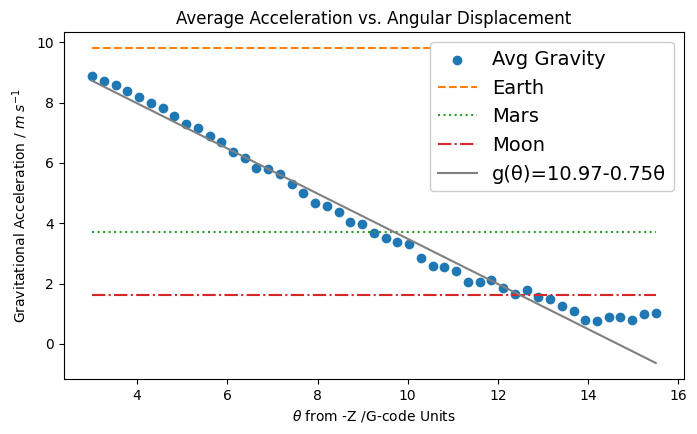

In [11]:
# Load mean gravity if available
mean_z_gravity = pd.read_csv('mean_z_gravity.csv')
x = np.linspace(3,15.5,49)

# Linear regression of average gravity as a function of maximum azmuth
# The last 6 points have been dropped because they skew the trend
slope, intercept = np.polyfit(x[:45],abs(mean_z_gravity[:45]*10),1)
print(slope,intercept)

fig, ax = plt.subplots(figsize=(8,4.5))
ax.scatter(x,abs(mean_z_gravity)*10,label="Avg Gravity")
ax.hlines(9.81,x[0],x[-1],colors='tab:orange',label="Earth",linestyles='dashed')
ax.hlines(3.72,x[0],x[-1],colors='tab:green',label='Mars',linestyles='dotted')
ax.hlines(1.625,x[0],x[-1],colors='tab:red',label='Moon',linestyles='dashdot')

# Plot the regression line
theta_symbol  = "\u03B8"
plt.plot(x, intercept + slope * x, color='grey', label=f'g({theta_symbol})={intercept[0].round(2)}-{abs(slope)[0].round(2)}{theta_symbol}')

ax.legend(loc='upper right', framealpha=1,prop={'size':14})
ax.set_xlabel(r'$\theta$ from -Z /G-code Units')
ax.set_ylabel(r'Gravitational Acceleration / $m_ s^{-1}$')
ax.set_title('Average Acceleration vs. Angular Displacement')



In [13]:
exp_thetas = np.array([3,6,9,12,15])
print(exp_thetas*-0.75+10.97)
gravity_key = [[3,8.89],[6,6.2],[9,4.22],[12,2.1],[15,1]]

[ 8.72  6.47  4.22  1.97 -0.28]


In [23]:
print(mean_z_gravity)
print(mean_z_gravity[-6:])
print(x)

    -9.072548732457156317e-01
0                   -0.889233
1                   -0.873082
2                   -0.857929
3                   -0.837866
4                   -0.817386
5                   -0.799520
6                   -0.780959
7                   -0.754251
8                   -0.729208
9                   -0.716723
10                  -0.689344
11                  -0.668765
12                  -0.637682
13                  -0.616867
14                  -0.582994
15                  -0.579029
16                  -0.563019
17                  -0.529319
18                  -0.501412
19                  -0.468252
20                  -0.455811
21                  -0.436153
22                  -0.405657
23                  -0.396559
24                  -0.368349
25                  -0.352262
26                  -0.337926
27                  -0.330628
28                  -0.285913
29                  -0.259304
30                  -0.254167
31                  -0.242153
32        

In [19]:
# Linear regression of average gravity as a function of maximum azmuth
# The last 6 points have been dropped because they skew the trend
slope_rad, intercept_rad = np.polyfit(x_path_extended.MaxTheta.to_numpy()[:45]*np.pi/15.5,abs(mean_z_gravity[:45]),1)
slope, intercept = np.polyfit(x_path_extended.MaxTheta.to_numpy()[:45],abs(mean_z_gravity[:45]),1)

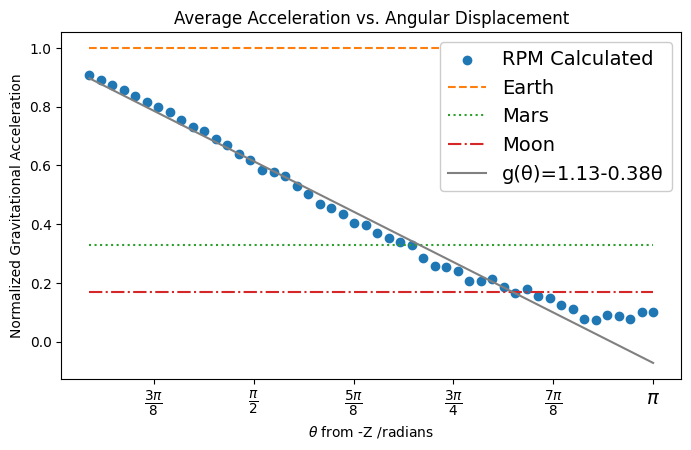

In [23]:
# Plot the average gravity
x = MaxTheta
fig, ax = plt.subplots(figsize=(8,4.5))

# Set the font family to Source Sans 3
#plt.rcParams['font.family'] = 'Source Sans 3'
#plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm']='DejaVu Sans'
plt.rcParams['font.family'] = 'DejaVu Sans'

# Set the x-axis tick locations
ax.set_xticks(np.linspace(0,15.5, 8))

# Set the x-axis tick labels as fractions of pi
ax.set_xticklabels([ r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$',
                    r'$\frac{\pi}{2}$', r'$\frac{5\pi}{8}$', r'$\frac{3\pi}{4}$', r'$\frac{7\pi}{8}$',r'$\pi$'])
#ax.set_yticklabels(['-1.0','-0.8','-0.6','-0.4','-0.2','0'])

# Increase the font size of the axes numbers
ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=10)

# Plot the data
ax.scatter(x,abs(mean_z_gravity),label = "RPM Calculated")
ax.hlines(1,x[0],x[-1],colors='tab:orange',label="Earth",linestyles='dashed')
ax.hlines(0.33,x[0],x[-1],colors='tab:green',label='Mars',linestyles='dotted')
ax.hlines(0.17,x[0],x[-1],colors='tab:red',label='Moon',linestyles='dashdot')
# Plot the regression line
theta_symbol  = "\u03B8"
plt.plot(x, intercept + slope * x, color='grey', label=f'g({theta_symbol})={intercept_rad.round(2)}-{abs(slope_rad).round(2)}{theta_symbol}')

ax.legend(loc='upper right', framealpha=1,prop={'size':14})
ax.set_xlabel(r'$\theta$ from -Z /radians')
ax.set_ylabel('Normalized Gravitational Acceleration')
ax.set_title('Average Acceleration vs. Angular Displacement')

plt.show()


In [11]:
mean_z_gravity[:44]

array([-0.90725487, -0.88923305, -0.8730821 , -0.85792886, -0.83786646,
       -0.81738584, -0.79951994, -0.78095903, -0.75425125, -0.72920787,
       -0.7167225 , -0.68934436, -0.66876506, -0.6376823 , -0.61686745,
       -0.58299389, -0.5790287 , -0.56301944, -0.52931918, -0.50141187,
       -0.46825216, -0.45581052, -0.43615334, -0.40565742, -0.39655877,
       -0.36834938, -0.35226214, -0.33792587, -0.3306279 , -0.28591255,
       -0.25930418, -0.25416678, -0.24215282, -0.20636399, -0.20502591,
       -0.2126147 , -0.18522455, -0.16430719, -0.1781201 , -0.15700775,
       -0.15004856, -0.12614771, -0.1103809 , -0.07752904])

In [14]:
#Find the closest theta_max to the moon and mars gravity
mars_index = np.argmin(np.abs(np.array(mean_z_gravity)+0.372))
moon_index = np.argmin(np.abs(np.array(mean_z_gravity)+0.1625))

print(mars_index,moon_index)

24 36


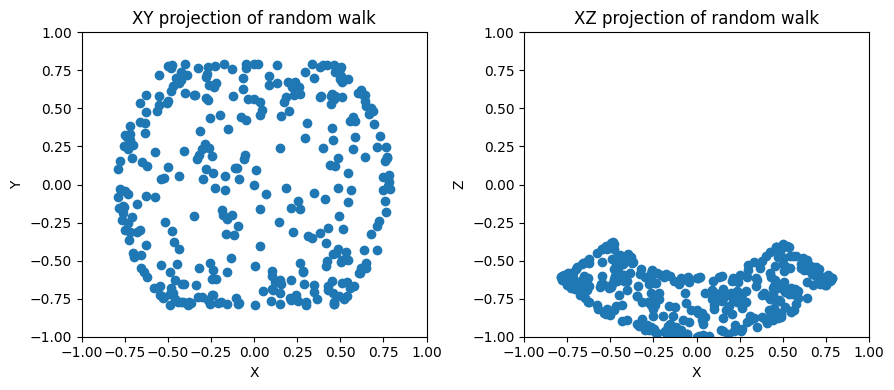

In [14]:
#Take a look an the XY projection of a path
target_theta_value = 4.5
closest_index = np.argmin(np.abs(np.array(MaxTheta)-target_theta_value))
path = x_path.isel(MaxTheta=closest_index).to_dataframe()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4))

samp = 15 # downsamples to 1 out of every 15 points

# Plot 1
ax1.scatter(path.X.iloc[::samp],path.Y.iloc[::samp])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('XY projection of random walk')
ax1.set_xlim(-1,1)
ax1.set_ylim(-1,1)

# Plot 2
ax2.scatter(path.X.iloc[::samp],path.Z.iloc[::samp])
ax2.set_xlabel('X')
ax2.set_ylabel('Z')
ax2.set_title('XZ projection of random walk')
ax2.set_xlim(-1,1)
ax2.set_ylim(-1,1)

plt.tight_layout()
plt.show()

## Averaging window width

This section looks at averaging the time window of each theta value calculated in the previous section.

The resampled data stored in x_grav is evenly spaced and with a constant velocity this means that the points are also evenly spaced in time. To convert from from the distance step of 0.01mm/step in the above resampled code to time we divide by the feed rate which is in mm/min. The time step in the resampled data is 0.004sec @150mm/min and 0.00171sec @350mm/min.

In [13]:
# Average gravity as a function of limited rotation
# For 5000 points this takes about 6min on a laptop.
MaxTheta = np.array([3,6,9,12,15]) 
gravity = [RandomWalk2D(5000,i,i).generate_walk().get_path() for i in MaxTheta]
x_path = xr.concat([grav.to_xarray() for grav in gravity],dim='MaxTheta')
x_path['MaxTheta'] = ('MaxTheta',MaxTheta)

# Resample the data from the random walk
step_size = 0.01
path_list = []

for i,max in enumerate(MaxTheta):
    data = interpolate_points(x_path.isel(MaxTheta=i)['Phi'].values,x_path.isel(MaxTheta=i)['Theta'].values,step_size)
    path_list.append(xr.Dataset(
        data_vars={
        "Phi": (("index", "MaxTheta"), data[:,0][:, np.newaxis]),
        "Theta": (("index", "MaxTheta"), data[:,1][:, np.newaxis]),
    },
    coords={
        "index": np.arange(data[:,0].shape[0]),
        "MaxTheta": [max],  # Assuming there's only one MaxTheta value
    },))
min_length = np.min([pl['index'].shape[0] for pl in path_list])
x_path_extended = xr.concat([pl.isel(index=slice(0,min_length)) for pl in path_list],dim='MaxTheta')

# Add the X,Y,Z positions to the dataset as data variables. 
x_path_extended["X"], x_path_extended["Y"],x_path_extended["Z"]= xr.apply_ufunc(
    rpm2cartesian,
    x_path_extended["Phi"],
    x_path_extended["Theta"],
    input_core_dims=[["MaxTheta", "index"], ["MaxTheta", "index"]],
    output_core_dims=[["MaxTheta", "index"], ["MaxTheta", "index"], ["MaxTheta", "index"]],
    vectorize=True,
    dask="allowed",  # Use parallel computation with dask
    output_dtypes=[float, float, float],
)


In [14]:
# Define the window widths and increments
window_widths = np.logspace(3,5,5).round().astype(int)
# Define the MaxTheta values
max_thetas = x_path_extended['MaxTheta'].values
rolling_averages = {}
# Iterate over each MaxTheta value
for theta in max_thetas:
    rolling_averages[theta] = {}
    data = x_path_extended.sel(MaxTheta=theta)['Z'].dropna('index').to_numpy()
    for width in window_widths:
        rolling_averages[theta][width] = np.convolve(data, np.ones(width)/width, mode='valid')

In [15]:
# Create an empty xarray with dimensions MaxTheta and WindowWidth
rolling_averages = xr.Dataset(
                                data_vars = {'time':(('MaxTheta','WindowWidth','Time'),np.zeros((len(max_thetas), len(window_widths),x_path_extended['Z'].shape[1])))},
                                coords={'MaxTheta': max_thetas, 'WindowWidth': window_widths})

rolling_averages['time'].loc[dict(MaxTheta=6,WindowWidth=1000)]=x_path_extended['Z'].isel(MaxTheta=0)

print(rolling_averages)

ValueError: new dimensions ('Time',) must be a superset of existing dimensions ('index',)

In [16]:
# Iterate over each MaxTheta value
for theta in max_thetas:
    data = x_path_extended.sel(MaxTheta=theta)['Z']
    # Iterate over each window width
    for width in window_widths:
        rolling_averages['time'].loc[dict(MaxTheta=theta,WindowWidth=width)] = np.convolve(data, np.ones(width)/width, mode='same') # See numpy convolve for the same operator. Edge effecs may be present...

In [17]:
# Save to an hdf5 file, this is optional.
rolling_averages.to_netcdf('rolling_averages.nc')

In [2]:
# Load file 
rolling_averages = xr.open_dataset("rolling_averages.nc", engine='netcdf4')

In [4]:

window_widths = np.logspace(3,5,5).round().astype(int)
max_thetas = np.array([3,9,15]) 
rolling_averages.isel(MaxTheta=1).to_array().squeeze().T[np.max(window_widths):-np.max(window_widths)]

<xarray.DataArray (Time: 485207, WindowWidth: 5)>
array([[-0.35296168, -0.64123195, -0.59175757, -0.6765568 , -0.67724198],
       [-0.35263692, -0.64128755, -0.59178652, -0.67656519, -0.67724246],
       [-0.35231377, -0.64134227, -0.59181554, -0.67657356, -0.67724293],
       ...,
       [-0.8074524 , -0.74977459, -0.65225781, -0.65821994, -0.66175914],
       [-0.80742255, -0.74985065, -0.65222704, -0.65820571, -0.66175562],
       [-0.80739248, -0.7499264 , -0.65219627, -0.6581915 , -0.66175211]])
Coordinates:
    MaxTheta     int32 6
  * WindowWidth  (WindowWidth) int32 1000 3162 10000 31623 100000
    variable     <U4 'time'
Dimensions without coordinates: Time

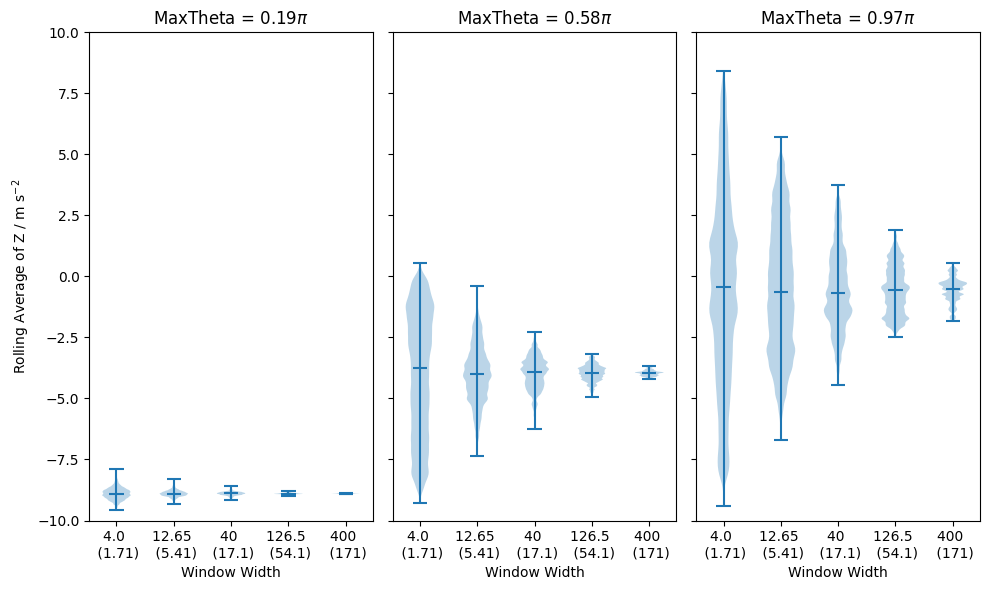

In [6]:
# Create a figure with subplots for each MaxTheta
fig, axs = plt.subplots(ncols=len(max_thetas), figsize=(10,6))
titles = ['$0.19\pi$','$0.58\pi$','$0.97\pi$']
for i,max_theta in enumerate(max_thetas):
        # Create a violin plot for the current MaxTheta
    ax = axs[i]
    ax.violinplot(9.81*rolling_averages.where(rolling_averages['MaxTheta']==max_theta,drop=True).to_array().squeeze().T[np.max(window_widths):-np.max(window_widths)], showextrema=True, showmedians=True)
    ax.set_xlabel('Window Width')
    ax.set_xticks(range(1, len(window_widths) + 1),[ f'4.0 \n (1.71)', f'12.65 \n (5.41)', f'40 \n (17.1)',f'126.5 \n (54.1)', f'400 \n (171)'])
    if i==0:
        ax.set_ylabel('Rolling Average of Z / m s$^{-2}$')
    else:
        ax.tick_params(labelleft=False)
    ax.set_ylim(-10,10)
    ax.set_title(f'MaxTheta = {titles[i]}')

# Adjust spacing between subplots
fig.tight_layout()

plt.show()


# Output to G-code

G-code output is reasonably straight forward. The first line needs to include a feedrate.

In [3]:
#Here we're regenerating the path from the top of the notebook becuase we want a clean theta value
path = [RandomWalk2D(5000,i,i).generate_walk().get_path() for i in [3,6,9,12,15]]

In [4]:
path[-1].describe()

,Theta,Phi,X,Y,Z
count,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000
mean,-0.228221,0.201782,-0.033565,-0.001028,0.037756
std,9.627843,9.745539,0.504571,0.670329,0.541953
min,-14.997995,-14.999443,-0.999835,-1.000000,-1.000000
25%,-9.163327,-8.667667,-0.404172,-0.629451,-0.359227
50%,-0.039588,0.131290,-0.029473,0.026607,0.031592
75%,8.511580,9.365610,0.304525,0.619434,0.462064
max,14.997390,14.998788,0.997721,0.999990,0.994449


In [5]:
theta = [3,6,9,12,15]
feedrate = [150,350]
for feed in feedrate:
    for i,angle in enumerate(theta):
        filename = f"{angle}Theta_F{feed}.gcode" #file extension is .gcode
        with open(filename,'w') as file:
            file.write(f'F{feed}\n')
            for index, row in path[i].iterrows():
                x = row['Theta'] # The machine x is the code Theta
                y = row['Phi']   # The machine y is the code Phi
                line = f'G01 x{x:0.2f}y{y:0.2f}\n'
                file.write(line)